In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import box
import geopandas as gpd
from subs import ptsinpoly
from matplotlib.patches import Polygon as MplPolygon

In [2]:
npfile = np.load(r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\theilslopes_DTW.npz')
print(npfile.files)

['dtw_syr', 'dtw_condyr', 'dtw_s_nmax_yr', 'dtw_nmax_yr', 'dtw_vyr', 'dtw_tyr', 'dtw_resyr', 'HydroID', 'lat', 'lon', 'dtw_interc_t', 'dtw_slop_t']


In [3]:
dtw_syr       = npfile.f.dtw_syr
dtw_condyr    = npfile.f.dtw_condyr
dtw_s_nmax_yr = npfile.f.dtw_s_nmax_yr
dtw_nmax_yr   = npfile.f.dtw_nmax_yr
dtw_tyr       = npfile.f.dtw_tyr
dtw_vyr       = npfile.f.dtw_vyr
dtw_resyr     = npfile.f.dtw_resyr
HydroID       = npfile.f.HydroID
lat           = npfile.f.lat
lon           = npfile.f.lon
dtw_interc_t  = npfile.f.dtw_interc_t
dtw_slop_t    = npfile.f.dtw_slop_t

In [4]:
regiones = gpd.read_file(r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\ARTÍCULO\australia_aquifers.shp')
print(regiones.columns)

Index(['Aquifer', 'Broader', 'Details', 'line_width', 'geometry'], dtype='object')


In [5]:
dtw_slop_t_valid = dtw_slop_t[~np.isnan(dtw_slop_t)] ## quito los valores nan de la serie

In [6]:
regiones_coords = [
    {
        'Broader': region['Broader'],
        'pflat': region.geometry.exterior.xy[1],  # Latitudes del polígono
        'pflon': region.geometry.exterior.xy[0],  # Longitudes del polígono
    }
    for _, region in regiones.iterrows()
]

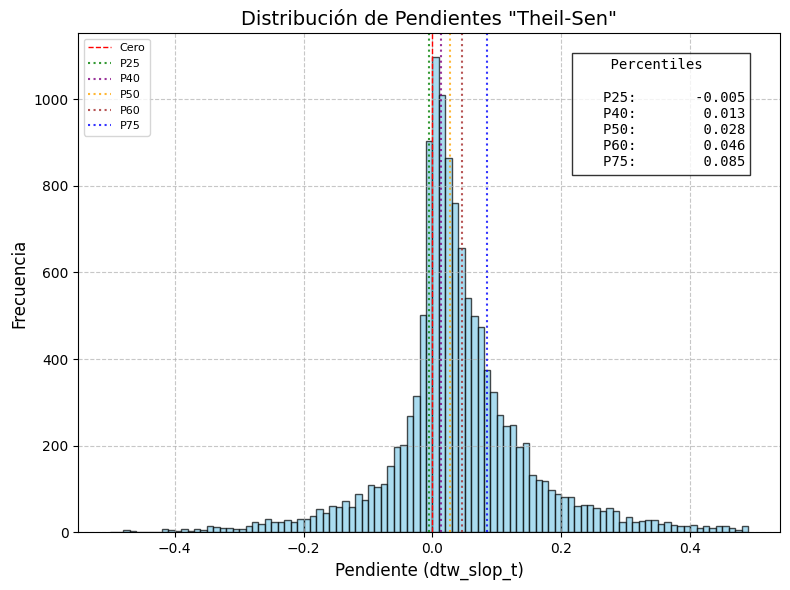

In [6]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.hist(dtw_slop_t_valid, bins=np.arange(-0.5, 0.5, 0.01), color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_title('Distribución de Pendientes "Theil-Sen"', fontsize=14)
ax1.set_xlabel('Pendiente (dtw_slop_t)', fontsize=12)
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.grid(axis='both', linestyle='--', alpha=0.7)

# Línea vertical en cero (roja)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=1, label='Cero')

# --- Cálculo de percentiles ---
percentiles = {
    'P25': np.percentile(dtw_slop_t_valid, 25),
    'P40': np.percentile(dtw_slop_t_valid, 40),
    'P50': np.percentile(dtw_slop_t_valid, 50),  # Equivalente a la mediana
    'P60': np.percentile(dtw_slop_t_valid, 60),
    'P75': np.percentile(dtw_slop_t_valid, 75)
}

# --- Líneas verticales para percentiles (colores distintos) ---
colors = ['green', 'purple', 'orange', 'brown', 'blue']
for (name, value), color in zip(percentiles.items(), colors):
    ax1.axvline(x=value, color=color, linestyle=':', linewidth=1.5, alpha=0.8, label=name)

# --- Texto de percentiles (esquina superior derecha) ---
percentiles_text = (
    f'{"Percentiles":^20}\n\n'
    f'{"P25:":<8} {percentiles["P25"]:>8.3f}\n'
    f'{"P40:":<8} {percentiles["P40"]:>8.3f}\n'
    f'{"P50:":<8} {percentiles["P50"]:>8.3f}\n'
    f'{"P60:":<8} {percentiles["P60"]:>8.3f}\n'
    f'{"P75:":<8} {percentiles["P75"]:>8.3f}'
)

plt.text(0.95, 0.95, percentiles_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.8),
         fontfamily='monospace')

# --- Leyenda unificada ---
plt.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\histogramas\percentiles\histograma_general.png', 
            dpi=300, bbox_inches='tight')
plt.show()

#### Cuencas

In [7]:
# Crear lista de geometrías de puntos
puntos_geom = [Point(lon[i], lat[i]) for i in range(len(lon))]

# 4. Realizar join espacial manualmente
broaders = np.empty(len(puntos_geom), dtype=object)
broaders[:] = None  # Inicializar como None

for idx, acuifero in regiones.iterrows():
    poly = acuifero.geometry
    mask = np.array([poly.contains(p) for p in puntos_geom])
    broaders[mask] = acuifero['Broader']

# 5. Filtrar datos válidos
valid_mask = ~np.isnan(dtw_slop_t) & (broaders != None)
dtw_valid = dtw_slop_t[valid_mask]
broaders_valid = broaders[valid_mask]

# 6. Obtener acuíferos únicos
unique_broaders = np.unique(broaders_valid)

# 7. Crear histogramas con percentiles
output_folder = r'G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\histogramas\percentiles\regiones'
os.makedirs(output_folder, exist_ok=True)

for acuifero in unique_broaders:
    if acuifero == '-':  # Saltar acuíferos sin nombre
        continue
        
    mask = broaders_valid == acuifero
    datos = dtw_valid[mask]
    
    if len(datos) > 0:
        # Calcular PERCENTILES (25, 40, 50, 60, 75)
        percentiles = {
            'P25': np.percentile(datos, 25),
            'P40': np.percentile(datos, 40),
            'P50': np.percentile(datos, 50),  # Equivalente a la mediana
            'P60': np.percentile(datos, 60),
            'P75': np.percentile(datos, 75)
        }
        
        # --- Crear histograma ---
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Histograma principal
        ax.hist(datos, bins=np.arange(-0.5, 0.5, 0.01), 
                color='skyblue', edgecolor='black', alpha=0.7)
        
        # --- Líneas de referencia ---
        # 1. Línea en cero (roja)
        ax.axvline(x=0, color='red', linestyle='--', linewidth=1, label='Cero')
        
        # 2. Líneas para percentiles (colores distintos)
        colors = ['green', 'purple', 'orange', 'brown', 'blue']
        for (name, value), color in zip(percentiles.items(), colors):
            ax.axvline(x=value, color=color, linestyle=':', 
                      linewidth=1.5, alpha=0.8, label=name)
        
        # --- Configuración del gráfico ---
        ax.set_title(f'Distribución de Pendientes - {acuifero}', fontsize=14)
        ax.set_xlabel('Pendiente (dtw_slop_t)', fontsize=12)
        ax.set_ylabel('Frecuencia', fontsize=12)
        ax.grid(axis='both', linestyle='--', alpha=0.7)
        
        # --- Texto de PERCENTILES (esquina superior derecha) ---
        percentiles_text = (
            f'{"Percentiles":^20}\n\n'
            f'{"P25:":<8} {percentiles["P25"]:>8.3f}\n'
            f'{"P40:":<8} {percentiles["P40"]:>8.3f}\n'
            f'{"P50:":<8} {percentiles["P50"]:>8.3f}\n'
            f'{"P60:":<8} {percentiles["P60"]:>8.3f}\n'
            f'{"P75:":<8} {percentiles["P75"]:>8.3f}'
        )
        
        ax.text(0.95, 0.95, percentiles_text, transform=ax.transAxes,
                fontsize=10, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontfamily='monospace')
        
        # --- Leyenda ---
        ax.legend(loc='upper left', fontsize=8)
        
        # --- Guardar figura ---
        nombre_archivo = f"histograma_{acuifero.replace(' ', '_').replace('/', '_')}.png"
        fig.savefig(os.path.join(output_folder, nombre_archivo), 
                  dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Histograma con percentiles creado para: {acuifero}")
    else:
        print(f"Advertencia: No hay datos válidos para {acuifero}")

print("Proceso completado. Histogramas guardados en:", output_folder)

Histograma con percentiles creado para: Amadeus Basin
Histograma con percentiles creado para: Daly-Wiso-Georgina Basins
Histograma con percentiles creado para: Eucla Basin
Histograma con percentiles creado para: Gippsland Basin
Histograma con percentiles creado para: Great Artesian Basin
Histograma con percentiles creado para: Hamersley Basin
Histograma con percentiles creado para: Murray Basin
Histograma con percentiles creado para: Otway Basin
Histograma con percentiles creado para: Perth Basin
Histograma con percentiles creado para: Pilbara Craton
Histograma con percentiles creado para: St Vincent Basin
Proceso completado. Histogramas guardados en: G:\Mi unidad\Maestria\Proyecto de Grado\analisis_nf\datos\australia\_01_imagenes\histogramas\percentiles\regiones
